# CS584 Homework 5: Machine Translation

# With Attention Part

* English to French

## 1. Data preparation¶


In [1]:
import re
import string
from unicodedata import normalize
import numpy as np

In [2]:
"""
load_doc: loading file 
to_line: cutting the the whole file to line by line
clean_data: remove the symble, url, or other irrevalent information 

"""

def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

def to_line(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return lines

def clean_data(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for line in lines:
        # normalize unicode characters
        line = normalize('NFD', line).encode('utf-8', 'ignore')
        #print(line)
        line = line.decode('UTF-8')
            
        # tokenize on white space
        line = line.split()
            
        # convert to lowercase
        line = [word.lower() for word in line]
            
        # remove punctuation from each token
        line = [word.translate(table) for word in line]
            
         # remove non-printable chars form each token
        line = [re_print.sub('', w) for w in line]
        #print(line)
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
            
        # store as string
        cleaned.append(' '.join(line))
    return cleaned

In [3]:
# Using the first 30000 sentences to contruct dataset
data_len = 30000

en = load_doc('europarl-v7.fr-en.en')
en_lines = to_line(en)
fr = load_doc('europarl-v7.fr-en.fr')
fr_lines = to_line(fr)

if len(en_lines) == len(fr_lines):
    print('English sentencens match with French sentences \n')
    print('English sentence:', len(en_lines), '\n')
    print('French sentence:', len(fr_lines), '\n')
else :
    print('English sentencens does not match with French sentences')


English sentencens match with French sentences 

English sentence: 2007723 

French sentence: 2007723 



In [4]:
#cleaning english part and french part 
clean_en = clean_data(en_lines)[0:data_len]
clean_fr = clean_data(fr_lines)[0:data_len]

In [5]:
clean_en = np.array(clean_en)
clean_fr = np.array(clean_fr)

In [6]:
# A showcase 
print(clean_en[700])
print(clean_fr[700])

i should also like to make a few comments firstly mr berend regarding the assessment you have made of this sixth periodic report
je voudrais a mon tour faire quelques observations dabord sur le jugement que vous portez monsieur le rapporteur sur ce sixieme rapport periodique


In [7]:
input_texts = clean_en
target_texts = ['\t' + text + '\n' for text in clean_fr]

print('Length of input_texts:  ' + str(input_texts.shape))
print('Length of target_texts: ' + str(input_texts.shape))

#This dataset includes lots of long sentence
#But, if we set max length with a large number, CPU cannot handle that, so we set max_encode is 32
#Becuase we add '\t' and '\n' to target, so the max_decode is 34
max_encoder_seq_length = 32 
max_decoder_seq_length = 34

print('max length of input  sentences: %d' % (max_encoder_seq_length))
print('max length of target sentences: %d' % (max_decoder_seq_length))

Length of input_texts:  (30000,)
Length of target_texts: (30000,)
max length of input  sentences: 32
max length of target sentences: 34


## 2. Text Processing

* Text to Sequence
* One-hot embedding the sequence

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [9]:
def text2sequences(max_len, lines):
    tokenizer = Tokenizer(char_level=True, filters='')
    tokenizer.fit_on_texts(lines)
    seqs = tokenizer.texts_to_sequences(lines)
    seqs_pad = pad_sequences(seqs, maxlen=max_len, padding='post')
    return seqs_pad, tokenizer.word_index

encoder_input_seq, input_token_index = text2sequences(max_encoder_seq_length, 
                                                      input_texts)
decoder_input_seq, target_token_index = text2sequences(max_decoder_seq_length, 
                                                       target_texts)

print('shape of encoder_input_seq: ' + str(encoder_input_seq.shape))
print('shape of input_token_index: ' + str(len(input_token_index)))
print('shape of decoder_input_seq: ' + str(decoder_input_seq.shape))
print('shape of target_token_index: ' + str(len(target_token_index)))

shape of encoder_input_seq: (30000, 32)
shape of input_token_index: 27
shape of decoder_input_seq: (30000, 34)
shape of target_token_index: 29


In [10]:
num_encoder_tokens = len(input_token_index) +1
num_decoder_tokens = len(target_token_index) +1

print('num_encoder_tokens: ' + str(num_encoder_tokens))
print('num_decoder_tokens: ' + str(num_decoder_tokens))

num_encoder_tokens: 28
num_decoder_tokens: 30


In [11]:
from keras.utils import to_categorical

In [12]:
def onehot_encode(sequences, max_len, vocab_size):
    n = len(sequences)
    data = np.zeros((n, max_len, vocab_size))
    for i in range(n):
        data[i, :, :] = to_categorical(sequences[i], num_classes=vocab_size)
    return data

In [13]:
encoder_input_data = onehot_encode(encoder_input_seq, max_encoder_seq_length, num_encoder_tokens)
decoder_input_data = onehot_encode(decoder_input_seq, max_decoder_seq_length, num_decoder_tokens)

decoder_target_seq = np.zeros(decoder_input_seq.shape)
decoder_target_seq[:, 0:-1] = decoder_input_seq[:, 1:]
decoder_target_data = onehot_encode(decoder_target_seq, 
                                    max_decoder_seq_length, 
                                    num_decoder_tokens)

print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(30000, 32, 28)
(30000, 34, 30)
(30000, 34, 30)


* **Split the dataset to training part and validation part**
* **24000 training sentence, 6000 validation sentence**

In [14]:
rand_indices = np.random.permutation(data_len)

train_count = int(np.floor(data_len * 0.8))
train_indices = rand_indices[0:train_count]
val_indices = rand_indices[train_count:data_len]

input_texts_train = input_texts[train_indices]
target_texts_train = np.asarray(target_texts)[train_indices]

encoder_input_train = encoder_input_data[train_indices]
decoder_input_train = decoder_input_data[train_indices]
decoder_target_train = decoder_target_data[train_indices]

input_texts_val = input_texts[val_indices]
target_texts_val = np.asarray(target_texts)[val_indices]
encoder_input_val = encoder_input_data[val_indices]
decoder_input_val = decoder_input_data[val_indices]
decoder_target_val = decoder_target_data[val_indices]


## 3. Build Network

### 3.1 Encoder

In [15]:
from keras.layers import Input, LSTM
from keras.models import Model
from keras.layers import Bidirectional, Concatenate
import tensorflow as tf

latent_dim = 256

# inputs of the encoder network
encoder_inputs = Input(shape=(None, num_encoder_tokens), 
                       name='encoder_inputs')

# set the LSTM layer
#encoder_lstm = LSTM(latent_dim, return_state=True,dropout=0.5, name='encoder_lstm')
#encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)



encoder_bilstm = Bidirectional(LSTM(latent_dim, return_state=True,dropout=0.5, name='encoder_lstm'))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_inputs)

encoder_state_h = Concatenate()([forward_h, backward_h])
encoder_state_c = Concatenate()([forward_c, backward_c])

forward_states = [forward_h, forward_c]
encoder_state = [encoder_state_h,encoder_state_c]

# build the encoder network model
encoder_model = Model(inputs=encoder_inputs, 
                      outputs=encoder_state,
                      name='encoder')

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(encoder_model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=encoder_model, show_shapes=False,
    to_file='encoder.pdf'
)

encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, None, 28)     0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 512), (None, 583680      encoder_inputs[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 512)          0           bidirectional_1[0][2]      

 ### 3.2 Decoder network+ Attention

In [17]:
from keras.layers import Input, LSTM, Dense, Multiply, Activation
from keras.models import Model

In [18]:
# inputs of the decoder network
decoder_input_h = Input(shape=(latent_dim*2,), name='decoder_input_h')
decoder_input_c = Input(shape=(latent_dim*2,), name='decoder_input_c')
decoder_input_x = Input(shape=(None, num_decoder_tokens), name='decoder_input_x')



# set the LSTM layer
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, 
                    return_state=True, dropout=0.5, name='decoder_lstm')


# set attention layer
wc = Dense(latent_dim*2, activation='tanh')
# set the dense layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')

decoder_lstm_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_input_x, 
                                                                      initial_state=[decoder_input_h, decoder_input_c])


Wa = Dense(latent_dim*2)
score = Multiply()([decoder_lstm_outputs, Wa(decoder_input_h)])
alignment = Activation('softmax')(score)
context = Multiply()([alignment, decoder_input_h])

lstm_out = Concatenate()([context, decoder_lstm_outputs])


lstm_out = wc(lstm_out)


ws = Dense(num_decoder_tokens)
#logits = ws(lstm_out)

decoder_outputs1 = decoder_dense(lstm_out)



# build the decoder network model
decoder_model = Model(inputs=[decoder_input_x, decoder_input_h, decoder_input_c],
                      outputs=[decoder_outputs1, decoder_state_h, decoder_state_c],
                      name='decoder')

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(decoder_model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=decoder_model, show_shapes=False,
    to_file='decoder.pdf'
)

decoder_model.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_x (InputLayer)    (None, None, 30)     0                                            
__________________________________________________________________________________________________
decoder_input_h (InputLayer)    (None, 512)          0                                            
__________________________________________________________________________________________________
decoder_input_c (InputLayer)    (None, 512)          0                                            
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 512),  1112064     decoder_input_x[0][0]            
                                                                 decoder_input_h[0][0]      

In [20]:
# input layers
encoder_input_x = Input(shape=(None, num_encoder_tokens), name='encoder_input_x')
decoder_input_x = Input(shape=(None, num_decoder_tokens), name='decoder_input_x')

# connect encoder to decoder
encoder_final_states = encoder_model([encoder_input_x])

decoder_pred,_,_ = decoder_model([decoder_input_x]+encoder_final_states)



#decoder_lstm_output, _, _ = decoder_lstm(decoder_input_x, initial_state=encoder_final_states)
#decoder_pred = decoder_dense(decoder_lstm_output)



model = Model(inputs=[encoder_input_x, decoder_input_x], 
              outputs=decoder_pred, 
              name='model_training')

In [21]:
model.summary()

Model: "model_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    (None, None, 28)     0                                            
__________________________________________________________________________________________________
decoder_input_x (InputLayer)    (None, None, 30)     0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 512), (None, 583680      encoder_input_x[0][0]            
__________________________________________________________________________________________________
decoder (Model)                 [(None, None, 30), ( 1914910     decoder_input_x[0][0]            
                                                                 encoder[1][0]       

## 4. Training and Evaluate Model

### 4.1 Training

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [23]:
history = model.fit([encoder_input_train, decoder_input_train],  # training data
                      decoder_target_train,                       # labels (left shift of the target sequences)
                      batch_size=64, epochs=50, 
                      validation_data= ([encoder_input_val, decoder_input_val],decoder_target_val))

model.save('seq2seq.h5')

Train on 24000 samples, validate on 6000 samples
Epoch 1/50
24000/24000 [==============================] - 32s 1ms/step - loss: 2.4920 - val_loss: 2.0277
Epoch 2/50
24000/24000 [==============================] - 30s 1ms/step - loss: 2.1876 - val_loss: 1.8262
Epoch 3/50
24000/24000 [==============================] - 30s 1ms/step - loss: 2.0717 - val_loss: 1.7125
Epoch 4/50
24000/24000 [==============================] - 30s 1ms/step - loss: 1.9988 - val_loss: 1.6582
Epoch 5/50
24000/24000 [==============================] - 30s 1ms/step - loss: 1.9451 - val_loss: 1.5451
Epoch 6/50
24000/24000 [==============================] - 30s 1ms/step - loss: 1.9045 - val_loss: 1.5055
Epoch 7/50
24000/24000 [==============================] - 30s 1ms/step - loss: 1.8691 - val_loss: 1.4883
Epoch 8/50
24000/24000 [==============================] - 30s 1ms/step - loss: 1.8367 - val_loss: 1.4275
Epoch 9/50
24000/24000 [==============================] - 31s 1ms/step - loss: 1.8135 - val_loss: 1.4036
Epoch 

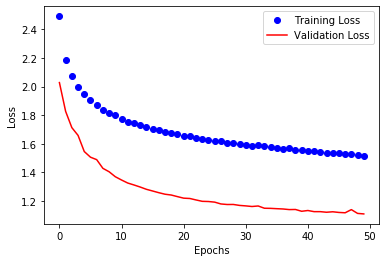

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4.2 Calculate BLEU Score on Val Part

In [25]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [26]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # this line of code is greedy selection
        # try to use multinomial sampling instead (with temperature)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
            output_tokens[0, -1, sampled_token_index] = 0
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [27]:
decoded_sentences = []
for i in range(encoder_input_val.shape[0]):
    decoded_sentences.append(decode_sequence(encoder_input_val[i: i + 1]))


In [28]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import nltk

val_scores = []
for i in range(target_texts_val.shape[0]):
    references = []
    split_result = target_texts_val[i][1:-1].split()
    references.append(split_result)
    candidate = decoded_sentences[i].split()
    val_scores.append(sentence_bleu(references, candidate, smoothing_function=SmoothingFunction().method2))

val_bleu_score = np.mean(val_scores)
print(val_bleu_score)

0.033205802915126745


## 5. Testing

* We take 1000 sentences from 40000 to 41000 in original file as the test part

In [29]:
test_en = clean_data(en_lines)[data_len+10000:data_len+11000]
test_fr = clean_data(fr_lines)[data_len+10000:data_len+11000]

test_en = np.array(test_en)
test_fr = np.array(test_fr)
target_texts_test = ['\t' + text + '\n' for text in test_fr]

In [30]:
def translation_sentence(input_sentence):
    input_seq_test, test_input_token = text2sequences(len(input_sentence), input_sentence)
    max_encoder_seq_length = max(len(line) for line in input_seq_test)
    input_x = onehot_encode(input_seq_test, max_encoder_seq_length, num_encoder_tokens)
    translated_sentence = decode_sequence(input_x)

    return translated_sentence


In [31]:
scores_test = []
for i in range(len(target_texts_test)):
    candidate = translation_sentence(test_en[i])
    reference = target_texts_test[i]
    score = sentence_bleu(reference, candidate, 
                          smoothing_function=SmoothingFunction().method2)
    scores_test.append(score)

In [32]:
test_bleu_score = np.mean(scores_test)
print(test_bleu_score)

0.5940973913275965


## Print 20 Sentences Example

In [41]:
lstm_result = []
for line in open("translation_without_attention.txt","r"):
    lstm_result.append(line)

In [42]:
for i in range(20):
    print('-')
    print('English:       ', test_en[i])
    print('Ground-truth Frehch: ', test_fr[i])
    print('Translation from seq2seq model: ', lstm_result[i])
    print('Translation from seq2seq plus attention: ', decoded_sentences[i])

-
English:        i think that the donor conference makes this possible or seems to at least
Ground-truth Frehch:  je pense que la conference des donateurs offre ou semble offrir cette possibilite
Translation from seq2seq model:  je peut est clos

Translation from seq2seq plus attention:  le projet de paix du moyenorient

-
English:        the third point i would like to make here is that there are parts of greece yes unfortunately greece for example the prefecture of pieria a tourist province in central macedonia which has suffered enormous economic damage because tourists no longer come to that area
Ground-truth Frehch:  troisieme point il existe des parties de grece oui de grece malheureusement comme le nome de pierie un nome touristique de la macedoine centrale qui ont subi un enorme prejudice economique du fait que les visiteurs ont deserte la region
Translation from seq2seq model:  

Translation from seq2seq plus attention:  res des cinorites et de la pache

-
English:        suc